In [7]:
# Import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import MeanIoU

In [2]:
# Load Stenosis annotation data
stenosis_train = pd.read_parquet("datasets/stenosis_train.parquet")
stenosis_val = pd.read_parquet("datasets/stenosis_val.parquet")
stenosis_test = pd.read_parquet("datasets/stenosis_test.parquet")

# Preview Stenosis annotation data
stenosis_train.head()

,image_id,segmentation,bbox,syntax_label
0,676,"[278.0, 291.75, 286.75, 299.25, 289.5, 296.25,...","[278.0, 245.12, 42.75, 54.13]",stenosis
1,960,"[294.75, 315.0, 293.0, 322.0, 298.5, 322.5, 30...","[293.0, 315.0, 68.0, 23.25]",stenosis
2,960,"[102.0, 172.25, 109.31, 179.25, 113.0, 175.75,...","[102.0, 157.38, 34.25, 21.87]",stenosis
3,960,"[87.69, 192.62, 96.69, 198.75, 95.81, 203.0, 9...","[84.38, 192.62, 12.31, 43.63]",stenosis
4,99,"[326.0, 232.62, 330.25, 231.38, 335.0, 239.75,...","[323.0, 221.25, 25.5, 26.13]",stenosis


In [3]:
# Helper function to load tensors from .tf files
def load_tensor_from_file(file_path):
    serialized_tensor = tf.io.read_file(file_path)
    tensor = tf.io.parse_tensor(serialized_tensor, out_type=tf.float32)
    return tensor

In [4]:
# Load tensors
X_train = load_tensor_from_file("datasets/X_train_stenosis.tf")
y_train = load_tensor_from_file("datasets/y_train_stenosis.tf")
X_val = load_tensor_from_file("datasets/X_val_stenosis.tf")
y_val = load_tensor_from_file("datasets/y_val_stenosis.tf")
X_test = load_tensor_from_file("datasets/X_test_stenosis.tf")
y_test = load_tensor_from_file("datasets/y_test_stenosis.tf")

In [5]:
#Build dice loss function
def dice_loss(y_true, y_pred):
    smooth = 1e-6  # To avoid division by zero
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_bce_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

In [8]:
# Build Model Architecture
def conv_block(input_tensor, num_filters):
    """Build the convolutional block for U-Net."""
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)  # Added Batch Normalization
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)  # Added Batch Normalization
    return(x)

def encoder_block(input_tensor, num_filters):
    """Downsample and build encoder block."""
    x = conv_block(input_tensor, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    """Upsample and concatenate the feature map from encoder."""
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = layers.concatenate([x, concat_tensor], axis=-1)
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape=(256, 256, 1)):
    """Build U-Net model."""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1, p1 = encoder_block(inputs, 32)
    c2, p2 = encoder_block(p1, 64)
    c3, p3 = encoder_block(p2, 128)
    c4, p4 = encoder_block(p3, 256)

    # Bridge
    b = conv_block(p4, 512)

    # Decoder
    d1 = decoder_block(b, c4, 256)
    d2 = decoder_block(d1, c3, 128)
    d3 = decoder_block(d2, c2, 64)
    d4 = decoder_block(d3, c1, 32)

    # Output
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

#Build U-Net model
tf.keras.backend.clear_session()
model = build_unet()
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam_optimizer, loss=dice_bce_loss, metrics=[MeanIoU(num_classes=2)])

# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[

 Total params: 7,771,297 (29.65 MB)

 Trainable params: 7,765,409 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [9]:
history = model.fit(
    x=X_train,
    y=tf.cast(y_train == 255, tf.float32),
    batch_size=32,
    epochs=10,
    validation_data=(X_val, tf.cast(y_val == 255, tf.float32))
)

Epoch 1/10
 2/82 ━━━━━━━━━━━━━━━━━━━━ 10:12 8s/step - loss: 1.6901 - mean_io_u: 0.4223 

KeyboardInterrupt: 

In [ ]:
y_pred = model.predict(X_test)

21/22 [===========================>..] - ETA: 0s

22/22 [==============================] - 2s 82ms/step


In [ ]:
predicted_masks = (y_pred > 0.5).astype(np.float32)

iou_metric = MeanIoU(num_classes=2)

# Update states with the ground truth and predictions
iou_metric.update_state(tf.cast(y_test == 255, tf.float32), predicted_masks)

# Get the IoU score
test_iou = iou_metric.result().numpy()
print(f"Test IoU: {test_iou}")

Test IoU: 0.49323585629463196


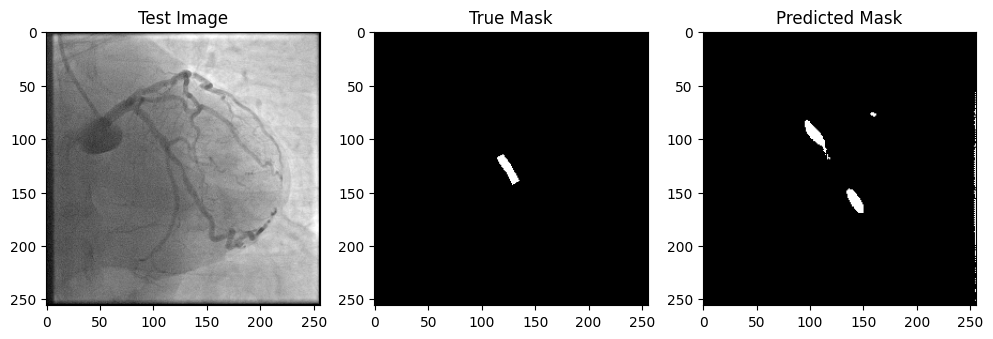

In [ ]:
# Example: Visualize the first test image, its true mask, and the predicted mask
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(tf.squeeze(X_test[1]), cmap='gray')  # Use tf.squeeze
plt.title('Test Image')
plt.subplot(1, 3, 2)
plt.imshow(tf.squeeze(y_test[1]), cmap='gray')  # Use tf.squeeze
plt.title('True Mask')
plt.subplot(1, 3, 3)
plt.imshow(tf.squeeze(predicßted_masks[1]), cmap='gray')  # Use tf.squeeze
plt.title('Predicted Mask')
plt.show()
